## test

In [1149]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [1150]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [1151]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test (Null: non-stationary)
result_adf = adfuller(df['GDP'])
print("ADF p-value:", result_adf[1])

# KPSS Test (Null: stationary)
from statsmodels.tsa.stattools import kpss
result_kpss = kpss(df['GDP'], regression='c')
print("KPSS p-value:", result_kpss[1])


ADF p-value: 0.6825705492402232
KPSS p-value: 0.01


/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_81688/3196527536.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df['GDP'], regression='c')


In [1152]:
# Because GDP is non-stationary, need to difference it
df['GDP_diff'] = df['GDP'].diff().dropna()
# Because r is non-stationary, need to difference it
df['r_diff'] = df['r'].diff().dropna()

# Define the high-volatility regime and fit the VAR model if not already done
threshold_var = df['Bitcoin'].shift(1)
theta = threshold_var.median()
regime_high = df[threshold_var > theta].dropna()
vars_to_model = ['GDP_diff', 'r_diff']

from statsmodels.tsa.api import VAR
model_high = VAR(regime_high[vars_to_model])
results_high = model_high.fit(maxlags=1)

# Use the correct fitted VAR model for the high regime
fitted_diff = results_high.fittedvalues['GDP_diff']
fitted_level = fitted_diff.cumsum() + df['GDP'].iloc[0]


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [1153]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test (Null: non-stationary)
result_adf = adfuller(df['r'])
print("ADF p-value:", result_adf[1])

# KPSS Test (Null: stationary)
from statsmodels.tsa.stattools import kpss
result_kpss = kpss(df['r'], regression='c')
print("KPSS p-value:", result_kpss[1])


ADF p-value: 0.22215361074121293
KPSS p-value: 0.01


/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_81688/1453321110.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df['r'], regression='c')


In [1154]:
# Because r is non-stationary, need to difference it
df['r_diff'] = df['r'].diff().dropna()

In [1155]:
threshold_var = df['Bitcoin'].shift(1) # lagged threshold
theta = threshold_var.median()

regime_low = df[threshold_var <= theta]. dropna()
regime_high = df[threshold_var > theta].dropna()

#Select VAR variables
vars_to_model = ['GDP_diff', 'r_diff']

#Fit VAR on low volatility regime
model_low = VAR(regime_low[vars_to_model])
results_low = model_low.fit(maxlags=1)

# Fit VAR on high-volatility regime
model_high = VAR(regime_high[vars_to_model])
results_high = model_high.fit(maxlags=1)

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [1156]:
print ("LOW volatility regime:")
print(results_low.summary())

print("HIGH volatility regime:")
print(results_high.summary())

LOW volatility regime:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Jun, 2025
Time:                     12:00:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.2962
Nobs:                     39.0000    HQIC:                   10.1321
Log likelihood:          -300.462    FPE:                    22945.1
AIC:                      10.0403    Det(Omega_mle):         19784.3
--------------------------------------------------------------------
Results for equation GDP_diff
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             -59.776045       110.183148           -0.543           0.587
L1.GDP_diff        -0.254731         0.138619           -1.838           0.066
L1.r_diff        2248.008808       455.543

/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_81688/753619206.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.Series(forecast_high[:,0], index=pd.date_range(start=df.index[-1], periods=5, freq='M')),


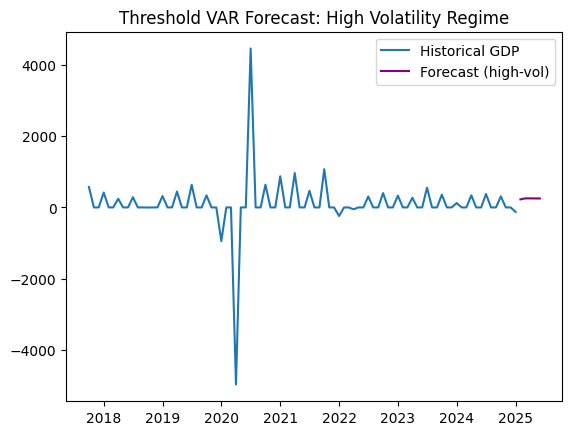

In [1157]:
forecast_high = results_high.forecast(y=regime_high[vars_to_model].values[-1:], steps=5)

plt.plot(df['GDP_diff'], label='Historical GDP')
plt.plot(pd.Series(forecast_high[:,0], index=pd.date_range(start=df.index[-1], periods=5, freq='M')),
         label='Forecast (high-vol)', color='purple')
plt.legend()
plt.title("Threshold VAR Forecast: High Volatility Regime")
plt.show()


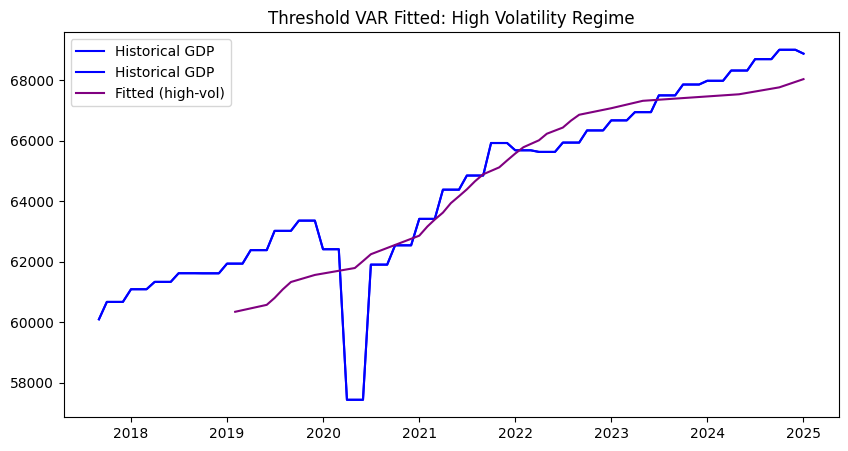

In [1158]:
# Historical GDP
plt.figure(figsize=(10, 5))
plt.plot(df['GDP'], label='Historical GDP', color='blue')

# Fitted values from the high-volatility regime
plt.plot(df['GDP'], label='Historical GDP', color='blue')
plt.plot(fitted_level, label='Fitted (high-vol)', color='purple')
plt.title("Threshold VAR Fitted: High Volatility Regime")
plt.legend()
plt.show()



## Training model on 2018-2022 and forecasting 2023-2025 with VAR

In [1159]:
# Split the data into training and testing sets
train = df.loc['2017-09':'2022-01']
test = df.loc['2022-02': '2025-1']

In [1160]:
from statsmodels.tsa.api import VAR

data = train[['GDP_diff', 'Bitcoin']].dropna()
model = VAR(data)
results = model.fit(maxlags=1)

forecast = results.forecast(y=train[['GDP_diff', 'Bitcoin']].values[-1:], steps=len(test))



/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


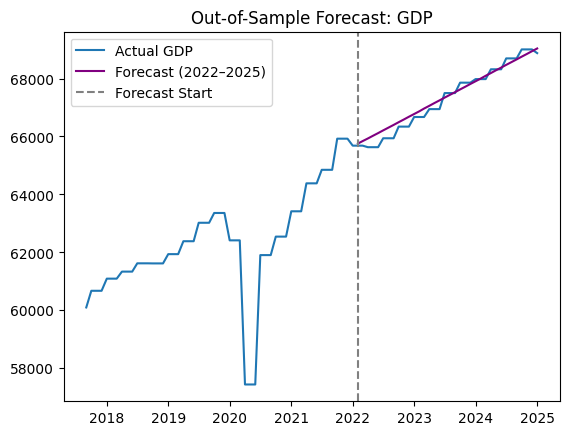

In [1161]:
# Extract the GDP forecast (column 0)
forecast_series = pd.Series(forecast[:, 0], index=test.index)

# Starting from the last known actual GDP level
gdp_start = df['GDP'].loc[train.index[-1]]

# Reconstruct GDP forecast from differences
forecast_gdp = forecast_series.cumsum() + gdp_start

# Plot results
import matplotlib.pyplot as plt

plt.plot(df['GDP'], label='Actual GDP')
plt.plot(forecast_gdp, label='Forecast (2022–2025)', color='purple')
plt.axvline(x=pd.to_datetime('2022-02-01'), linestyle='--', color='gray', label='Forecast Start')
plt.title("Out-of-Sample Forecast: GDP")
plt.legend()
plt.show()


In [1162]:
# calculate the mean absolute error (MAE) for the forecast
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df['GDP']['2022-02': '2025-01'], forecast_gdp)
print("Mean Absolute Error (MAE) of the forecast:", mae)

from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(df['GDP']['2022-02': '2025-01'], forecast_gdp)
print("Mean Absolute Percentage Error (MAPE) of the forecast:", mape)

Mean Absolute Error (MAE) of the forecast: 182.85800837246884
Mean Absolute Percentage Error (MAPE) of the forecast: 0.0027356938046813493


## Testing the same data with TVAR

In [1163]:
# defining the threshold
theta = df['Bitcoin'].median()

In [1164]:
#split the training data into two regimes
train = df['2017-09':'2022-01'].dropna()
regime_low = train[train['Bitcoin'] <= theta]
regime_high = train[train['Bitcoin'] > theta]

In [1165]:
# fit a VAR model to each of the regimes
model_low = VAR(regime_low[['GDP_diff', 'Bitcoin']])
results_low = model_low.fit(maxlags=1)

model_high = VAR(regime_high[['GDP_diff', 'Bitcoin']])
results_high = model_high.fit(maxlags=1)

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [1166]:
# forecast loop using regime switching
forecast_steps = len(df['2022-02': '2025-01'])
initial_values = train[['GDP_diff', 'Bitcoin']].values[-1:].copy()

regimes = []
forecast_results = []
current_values = initial_values.copy()

for i in range(forecast_steps):
    vol_index = len(train) + i - 1  # lagged Bitcoin
    btc_vol = df['Bitcoin'].iloc[vol_index]

    # Choose the appropriate model
    model = results_high if btc_vol > theta else results_low

    # Forecast one step
    forecast = model.forecast(current_values, steps=1)
    forecast_results.append(forecast[0])  # flatten the result

    # Update current_values for next step
    current_values = np.vstack([current_values[1:], forecast])

In [1167]:
forecast_array = np.array(forecast_results)
forecast_df = pd.DataFrame(forecast_array, columns=['GDP_diff', 'Bitcoin'], index=df['2022-02':'2025-01'].index)

# Reconstruct GDP level
gdp_start = df['GDP'].loc[train.index[-1]]
forecast_gdp = forecast_df['GDP_diff'].cumsum() + gdp_start

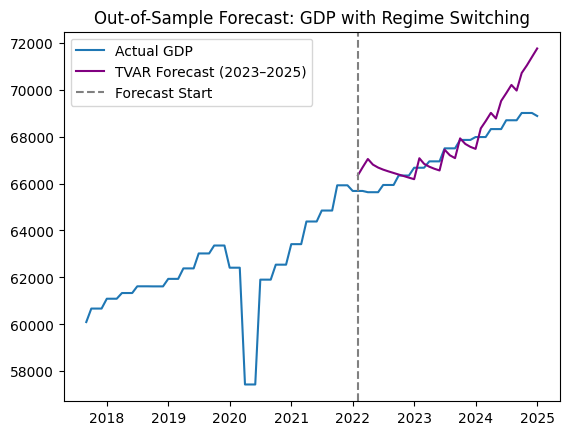

Low Volatility Regime Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Jun, 2025
Time:                     12:00:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.3136
Nobs:                     14.0000    HQIC:                   12.0144
Log likelihood:          -118.008    FPE:                    171649.
AIC:                      12.0397    Det(Omega_mle):         116412.
--------------------------------------------------------------------
Results for equation GDP_diff
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const            2186.441053      3221.474751            0.679           0.497
L1.GDP_diff        -0.019109         0.320435           -0.060           0.952
L1.Bitcoin        884.350983      

In [1168]:
# plot the forecast 
plt.plot(df['GDP'], label='Actual GDP')
plt.plot(forecast_gdp, label='TVAR Forecast (2023–2025)', color = 'purple')
plt.axvline(x=pd.to_datetime('2022-02-01'), linestyle='--', color='gray', label='Forecast Start')
plt.legend()
plt.title("Out-of-Sample Forecast: GDP with Regime Switching")
plt.show()

# Print the summary of the VAR model results
print("Low Volatility Regime Summary:")
print(results_low.summary())

print("High Volatility Regime Summary:")
print(results_high.summary())
# Print the forecast results
print("Forecast Results:")
print(forecast_df.head())
# Print the fitted values for the high-volatility regime
print("Fitted Values (High Volatility Regime):")
print(fitted_level.head())


In [1169]:
# calculate the mean absolute error (MAE) for the forecast
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df['GDP']['2022-02': '2025-01'], forecast_gdp)
print("Mean Absolute Error (MAE) of the forecast:", mae)

from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(df['GDP']['2022-02': '2025-01'], forecast_gdp)
print("Mean Absolute Percentage Error (MAPE) of the forecast:", mape)

Mean Absolute Error (MAE) of the forecast: 758.8680687245292
Mean Absolute Percentage Error (MAPE) of the forecast: 0.011206970325288165


## TVAR forecast with regimes labelled

In [1170]:
# Reconstruct regimes for the forecast period
forecast_btc = df.loc[forecast_gdp.index, 'Bitcoin'].shift(1)  # lagged Bitcoin for each forecast step
forecast_regimes = np.where(forecast_btc > theta, 'high', 'low')

forecast_plot_df = pd.DataFrame({
    'forecast_gdp': forecast_gdp,
    'regime': forecast_regimes
}, index=forecast_gdp.index)

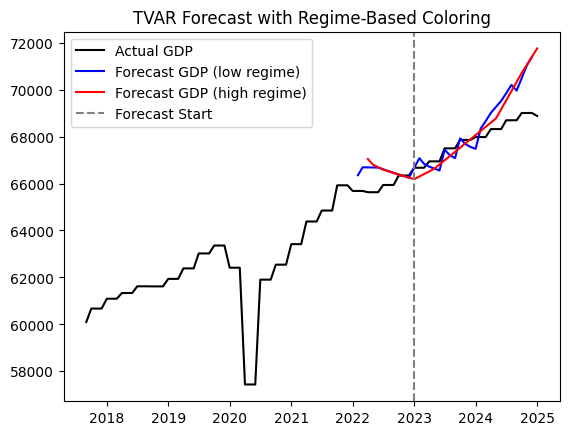

In [1171]:
import matplotlib.pyplot as plt

plt.plot(df['GDP'], label='Actual GDP', color='black')

# Plot forecast line in segments by regime
for regime_value in ['low', 'high']:
    segment = forecast_plot_df[forecast_plot_df['regime'] == regime_value]
    plt.plot(segment.index, segment['forecast_gdp'],
             label=f'Forecast GDP ({regime_value} regime)',
             color='blue' if regime_value == 'low' else 'red')

# Add forecast start line
plt.axvline(pd.to_datetime('2023-01-01'), linestyle='--', color='gray', label='Forecast Start')
plt.title("TVAR Forecast with Regime-Based Coloring")
plt.legend()
plt.show()


## VAR test with just GDP forecasting itself

In [1172]:
# Split the data into training and testing sets
train = df.loc['2017-09':'2022-01']
test = df.loc['2022-02': '2025-1']

In [1173]:
from statsmodels.tsa.api import AutoReg

# Drop NaNs from the training data
gdp_diff_train = train['GDP_diff'].dropna()

model_ar = AutoReg(gdp_diff_train, lags=1)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


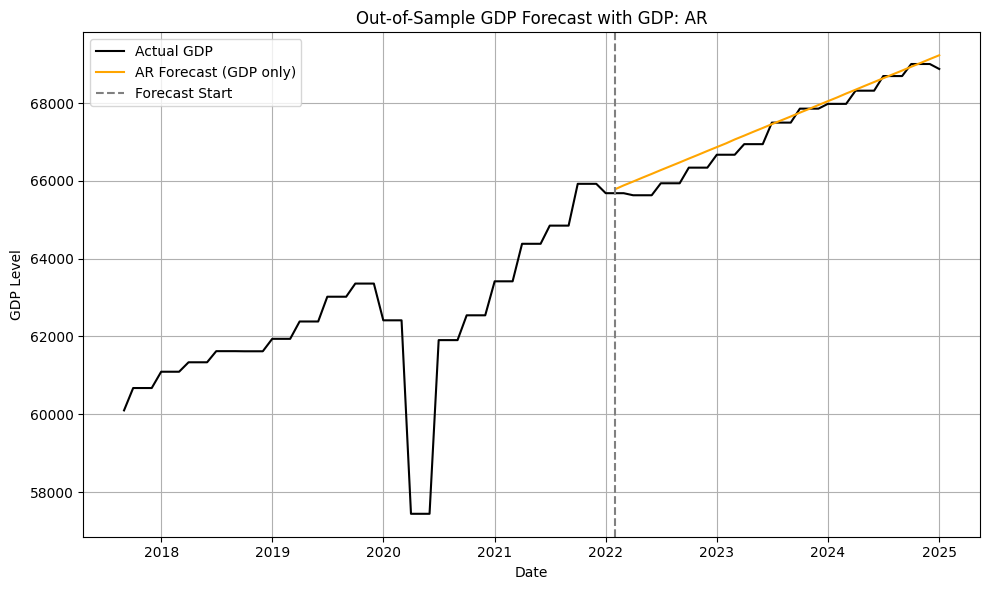

In [1174]:
gdp_start = df['GDP'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + gdp_start

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Actual GDP
plt.plot(df['GDP'], label='Actual GDP', color='black')

# AR model forecast
plt.plot(forecast_ar_level, label='AR Forecast (GDP only)', color='orange')
# Forecast start marker
plt.axvline(pd.to_datetime('2022-02-01'), linestyle='--', color='gray', label='Forecast Start')

# Plot formatting
plt.title('Out-of-Sample GDP Forecast with GDP: AR')
plt.xlabel('Date')
plt.ylabel('GDP Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1175]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# 1. Get actual values
actual = df.loc[test.index, 'GDP']

# 2. MAE: Mean Absolute Error
mae_ar = mean_absolute_error(actual, forecast_ar_level)

# 3. MAPE: Mean Absolute Percentage Error
# Avoid divide-by-zero by filtering out any zero actuals (not common in GDP though)
mape_ar = (np.abs((actual - forecast_ar_level) / actual) * 100).mean()

# 4. Print results
print(f"AR MAE: {mae_ar:.2f}")
print(f"AR MAPE: {mape_ar:.2f}%")

AR MAE: 220.65
AR MAPE: 0.33%


## VAR forecast of fed funds rate with all crypto

In [1176]:
# Split the data into training and testing sets
train = df.loc['2017-09':'2022-10']
test = df.loc['2022-11': '2025-1']

In [1177]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test (Null: non-stationary)
result_adf = adfuller(df['r'])
print("ADF p-value:", result_adf[1])

# KPSS Test (Null: stationary)
from statsmodels.tsa.stattools import kpss
result_kpss = kpss(df['r'], regression='c')
print("KPSS p-value:", result_kpss[1])


ADF p-value: 0.22215361074121293
KPSS p-value: 0.01


/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_81688/1453321110.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df['r'], regression='c')


In [1178]:
# Because lfpr is non-stationary with order 1, need to difference it
df['lfpr_diff'] = df['LFPR'].diff(2)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])


In [1179]:
from statsmodels.tsa.api import AutoReg

# Drop NaNs from the training data
r_diff_train = train['r_diff'].dropna()

model_ar = AutoReg(r_diff_train, lags=1)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1180]:
r_start = df['r'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + r_start

In [1181]:
# Get the last known actual r value from the training set
r_start = train['r'].loc[train.index[-1]]
p = 6

# Fit VAR model on r_diff and Bitcoin
model_btc = VAR(train[['r_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['r_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Tether
model_usdt = VAR(train[['r_diff', 'Tether']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['r_diff', 'Tether']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Litecoin
model_ltc = VAR(train[['r_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['r_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and XRP
model_xrp = VAR(train[['r_diff', 'XRP']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['r_diff', 'XRP']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Ethereum
model_eth = VAR(train[['r_diff', 'Ethereum']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['r_diff', 'Ethereum']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Dogecoin
model_doge = VAR(train[['r_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['r_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Cardano
model_ada = VAR(train[['r_diff', 'Cardano']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['r_diff', 'Cardano']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and USD Coin
model_usdc = VAR(train[['r_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['r_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + r_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

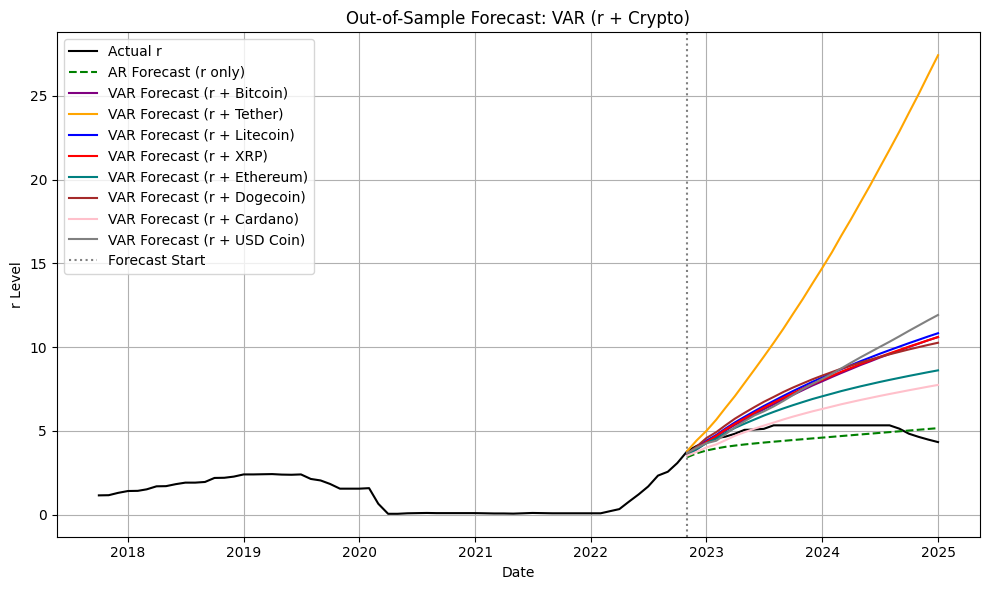

In [1182]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_r, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual r
plt.plot(df['r'], label='Actual r', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (r only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (r only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label='VAR Forecast (r + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (r + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (r + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (r + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (r + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (r + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (r + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (r + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (r + Crypto)')
plt.xlabel('Date')
plt.ylabel('r Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1183]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (r only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['r'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (r only)  MAPE: 12.59%
VAR + BTC    MAPE: 50.74%
VAR + USDT   MAPE: 188.78%
VAR + LTC    MAPE: 54.30%
VAR + XRP    MAPE: 51.78%
VAR + ETH    MAPE: 33.63%
VAR + DOGE   MAPE: 53.93%
VAR + ADA    MAPE: 22.87%
VAR + USDC   MAPE: 56.75%


In [1184]:
from sklearn.metrics import mean_squared_error
import numpy as np

for name, fc in forecasts.items():
    mse  = mean_squared_error(actual, fc)
    rmse = np.sqrt(mse)
    print(f"{name:12s} MSE: {mse:.4f}, RMSE: {rmse:.4f}")




AR (r only)  MSE: 0.4386, RMSE: 0.6623
VAR + BTC    MSE: 10.0977, RMSE: 3.1777
VAR + USDT   MSE: 138.8844, RMSE: 11.7849
VAR + LTC    MSE: 11.2677, RMSE: 3.3567
VAR + XRP    MSE: 10.3425, RMSE: 3.2160
VAR + ETH    MSE: 4.4310, RMSE: 2.1050
VAR + DOGE   MSE: 10.4387, RMSE: 3.2309
VAR + ADA    MSE: 2.2539, RMSE: 1.5013
VAR + USDC   MSE: 13.5298, RMSE: 3.6783


In [1185]:
# Apply the needed differences
diff_orders = {
    "r":      2,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -14.86     -14.56*   3.525e-07      -14.74
1      -17.36      -14.40   2.939e-08      -16.19
2      -17.22      -11.60   3.826e-08      -15.00
3      -17.79      -9.502   3.056e-08      -14.51
4      -17.78      -6.827   6.584e-08      -13.45
5      -18.94      -5.318   9.651e-08      -13.55
6     -25.35*      -9.057  4.367e-09*     -18.90*
-------------------------------------------------


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## VAR LFPR with all crypto

In [1186]:
# Split the data into training and testing sets
train = df.loc['2018-09':'2022-10']
test = df.loc['2022-11': '2025-1']

In [1187]:
# Because lfpr is non-stationary with order 1, need to difference it
df['lfpr_diff'] = df['LFPR'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])



In [1188]:
from statsmodels.tsa.api import AutoReg

# Ensure 'lfpr_diff' exists in train
if 'lfpr_diff' not in train.columns:
	train['lfpr_diff'] = df['lfpr_diff'].loc[train.index]

# Drop NaNs from the training data
lfpr_diff_train = train['lfpr_diff'].dropna()

model_ar = AutoReg(lfpr_diff_train, lags=1)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1189]:
lfpr_start = df['LFPR'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + lfpr_start

In [1190]:

p = 6

# Ensure train has the latest differenced columns from df
train = df.loc['2018-09':'2022-10']

# Fit VAR model on lfpr_diff and Bitcoin
model_btc = VAR(train[['lfpr_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['lfpr_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and usdt_diff
if 'usdt_diff' not in train.columns:
	train['usdt_diff'] = df['usdt_diff'].loc[train.index]
model_usdt = VAR(train[['lfpr_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['lfpr_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and Litecoin
model_ltc = VAR(train[['lfpr_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['lfpr_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and xrp_diff
model_xrp = VAR(train[['lfpr_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['lfpr_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and eth_diff
model_eth = VAR(train[['lfpr_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['lfpr_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and Dogecoin
model_doge = VAR(train[['lfpr_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['lfpr_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and ada_diff
model_ada = VAR(train[['lfpr_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['lfpr_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and USD Coin
model_usdc = VAR(train[['lfpr_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['lfpr_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + lfpr_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

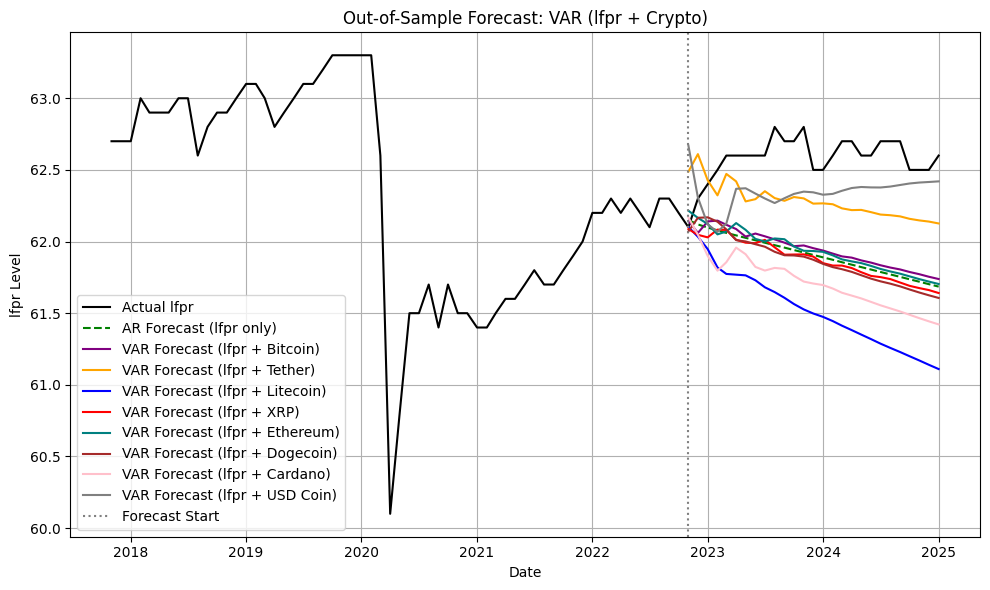

In [1191]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_lfpr, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual lfpr
plt.plot(df['LFPR'], label='Actual lfpr', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (lfpr only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (lfpr only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label='VAR Forecast (lfpr + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (lfpr + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (lfpr + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (lfpr + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (lfpr + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (lfpr + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (lfpr + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (lfpr + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (lfpr + Crypto)')
plt.xlabel('Date')
plt.ylabel('lfpr Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1192]:
import pandas as pd
from statsmodels.tsa.api import VAR

# Apply the needed differences
diff_orders = {
    "LFPR":      1,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -15.12     -14.82*   2.714e-07      -15.00
1      -16.40      -13.44   7.660e-08      -15.23
2      -16.44      -10.81   8.371e-08      -14.21
3      -17.08      -8.784   6.263e-08      -13.80
4      -17.00      -6.040   1.446e-07      -12.66
5      -17.82      -4.198   2.959e-07      -12.43
6     -23.13*      -6.843  3.997e-08*     -16.69*
-------------------------------------------------


Looking at AIC and HQIC minimums, we pick lag p=6

In [1193]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (lfpr only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['LFPR'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (lfpr only) MAPE: 1.08%
VAR + BTC    MAPE: 1.02%
VAR + USDT   MAPE: 0.56%
VAR + LTC    MAPE: 1.68%
VAR + XRP    MAPE: 1.13%
VAR + ETH    MAPE: 1.04%
VAR + DOGE   MAPE: 1.13%
VAR + ADA    MAPE: 1.39%
VAR + USDC   MAPE: 0.45%


## VAR Forecasting with GDP and all crypto

In [1194]:
# Split the data into training and testing sets
train = df.loc['2018-01':'2022-10']
test = df.loc['2022-11': '2025-1']

In [1195]:
# Apply the needed differences
diff_orders = {
    "GDP":      1,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.4590     0.7551*       1.583      0.5762
1     -0.8142       2.147      0.4520      0.3576
2     -0.6094       5.017      0.6278       1.617
3      -1.048       7.244      0.5726       2.233
4     -0.8162       10.14       1.541       3.520
5      -2.472       11.15       1.371       2.919
6     -9.445*       6.844    0.03513*     -2.999*
-------------------------------------------------


In [1196]:
# Because lfpr is non-stationary with order 1, need to difference it
df['gdp_diff'] = df['GDP Monthly'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])

In [1197]:
from statsmodels.tsa.api import AutoReg

# Ensure 'gdp_diff' exists in train
if 'gdp_diff' not in train.columns:
	train['gdp_diff'] = df['gdp_diff'].loc[train.index]

# Drop NaNs from the training data
gdp_diff_train = train['gdp_diff'].dropna()

model_ar = AutoReg(gdp_diff_train, lags=2)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1198]:
gdp_start = df['GDP Monthly'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + lfpr_start

In [1199]:

p = 6

# Ensure train has the latest differenced columns from df
train = df.loc['2017-09':'2022-10']

# Fit VAR model on gdp_diff and Bitcoin
model_btc = VAR(train[['gdp_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['gdp_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and usdt_diff
if 'usdt_diff' not in train.columns:
	train['usdt_diff'] = df['usdt_diff'].loc[train.index]
model_usdt = VAR(train[['gdp_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['gdp_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and Litecoin
model_ltc = VAR(train[['gdp_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['gdp_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and xrp_diff
model_xrp = VAR(train[['gdp_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['gdp_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and eth_diff
model_eth = VAR(train[['gdp_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['gdp_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and Dogecoin
model_doge = VAR(train[['gdp_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['gdp_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and ada_diff
model_ada = VAR(train[['gdp_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['gdp_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and USD Coin
model_usdc = VAR(train[['gdp_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['gdp_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + gdp_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

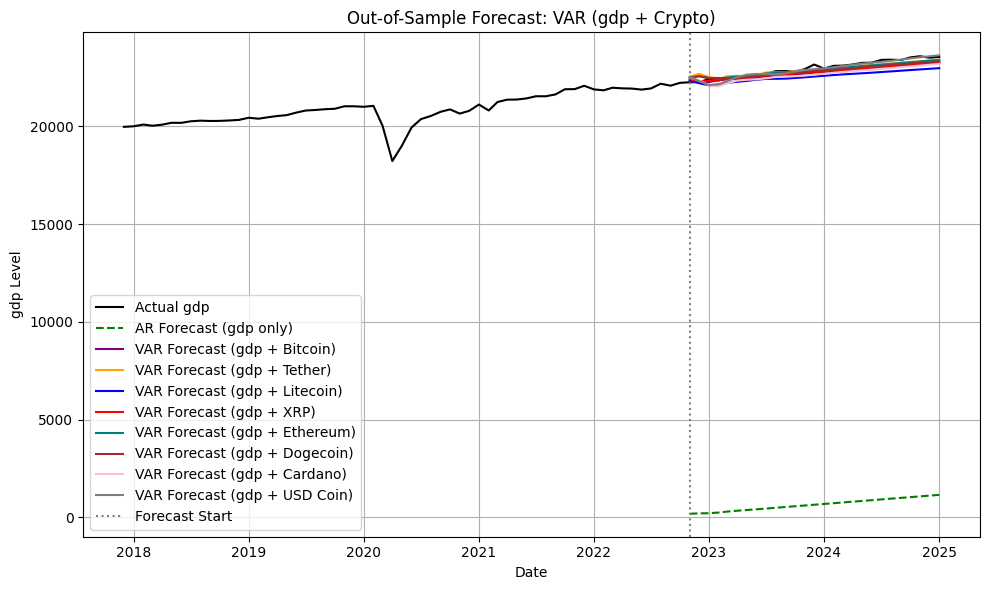

In [1200]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_gdp, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual gdp
plt.plot(df['GDP Monthly'], label='Actual gdp', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (gdp only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (gdp only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label='VAR Forecast (gdp + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (gdp + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (gdp + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (gdp + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (gdp + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (gdp + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (gdp + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (gdp + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (gdp + Crypto)')
plt.xlabel('Date')
plt.ylabel('gdp Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1201]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (gdp only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['GDP Monthly'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (gdp only) MAPE: 97.21%
VAR + BTC    MAPE: 0.95%
VAR + USDT   MAPE: 0.60%
VAR + LTC    MAPE: 1.75%
VAR + XRP    MAPE: 0.83%
VAR + ETH    MAPE: 0.57%
VAR + DOGE   MAPE: 0.75%
VAR + ADA    MAPE: 1.37%
VAR + USDC   MAPE: 0.38%


## VAR Forecasting of CPI with all crypto

In [1202]:
# Split the data into training and testing sets
train = df.loc['2018-01':'2022-10']
test = df.loc['2022-11': '2025-1']

In [1203]:
# Apply the needed differences
diff_orders = {
    "CPI":      2,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -11.90     -11.60*   6.793e-06      -11.78
1      -13.96      -11.00   8.862e-07      -12.78
2      -14.42      -8.789   6.334e-07      -12.19
3      -15.26      -6.964   3.867e-07      -11.97
4      -15.32      -4.362   7.740e-07      -10.98
5      -16.80      -3.174   8.236e-07      -11.41
6     -22.35*      -6.061  8.732e-08*     -15.90*
-------------------------------------------------


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Because lfpr is non-stationary with order 1, need to difference it
df['cpi_diff'] = df['CPI'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])